# Structure
* [Data Preparation](#data_prep)
* [Decision Tree Model](#decision_tree)
* [Random Forest Model](#random_forest)

In [75]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor as DTRegressor
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

import pickle

## <a id='data_prep'>Data Preparation</a>

In [76]:
df = pd.read_csv('heartRisk.csv')

#### At first we have to convert feature names to standard ones.

In [77]:
df.columns = [column_name.lower() for column_name in df.columns]
df.columns = [column_name.replace("is", "is_") if column_name.startswith('is') else column_name for column_name in df.columns ]

#### Shuffle and split dataset

In [78]:
X = df.drop(columns=['risk'])
y = df['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
def get_corr_coef(feature_1: str, feature_2: str) -> float:
    corr_coef = df[[feature_1, feature_2]].corr(method='kendall')
    corr_coef = corr_coef[feature_1][feature_2]

    return corr_coef

def show_correlation(feature_1: str, feature_2: str):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[feature_1], df[feature_2], color='blue', marker='o')
    plt.title(f"{feature_1} vs {feature_2}")
    plt.ylabel(feature_2)
    plt.xlabel(feature_1)
    plt.grid(True)
    plt.show()

In [80]:
features = df.columns
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        if i != j:
            corr_coef = get_corr_coef(features[i], features[j])
            if corr_coef >= 0.5 or corr_coef <= -0.5:
                show_correlation(features[i], features[j])
                print(f"{features[i]} & {features[j]} correlation coefficient is: {corr_coef}")

#### Despite we do not see any strong correlations, I speculate there is one feature we could add - 'good' cholesterol ratio

In [81]:
df['good_chosterol_ratio'] = df['hdl'] / df['cholesterol']

In [82]:
df.head()

,is_male,is_black,is_smoker,is_diabetic,is_hypertensive,age,systolic,cholesterol,hdl,risk,good_chosterol_ratio
0,1,1,0,1,1,49,101,181,32,11.1,0.176796
1,0,0,0,1,1,69,167,155,59,30.1,0.380645
2,0,1,1,1,1,50,181,147,59,37.6,0.401361
3,1,1,1,1,0,42,145,166,46,13.2,0.277108
4,0,0,1,0,1,66,134,199,63,15.1,0.316583


## <a id='decision_tree'>Decision Tree Model</a>

In [83]:
criterion = 'squared_error'
splitter = 'best'
random_state = 9

In [84]:
hparams_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 15],
    'max_features': [None, "sqrt", "log2"]
    }

In [85]:
model = DTRegressor(criterion = criterion, splitter = splitter, random_state = random_state)

In [86]:
gs_ds = GridSearchCV(model, hparams_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 3, return_train_score = True)

In [87]:
gs_ds.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2;, score=(train=-53.816, test=-86.548) total time=   0.0s
[CV 2/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2;, score=(train=-58.190, test=-74.998) total time=   0.0s
[CV 3/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2;, score=(train=-48.813, test=-116.118) total time=   0.0s
[CV 4/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2;, score=(train=-55.633, test=-83.332) total time=   0.0s
[CV 5/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2;, score=(train=-49.852, test=-108.027) total time=   0.0s
[CV 1/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10;, score=(train=-53.816, test=-86.548) total time=   0.0s
[CV 2/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=9),
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10, 15],
                         'min_samples_split': [2, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [88]:
def none_sub(grid: dict) -> dict:
    for ind, param in grid.items():
        for value_ind, value in enumerate(param):
            if value is None:
                grid[ind][value_ind] = 'None'


In [89]:

none_sub(gs_ds.param_grid)

In [90]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

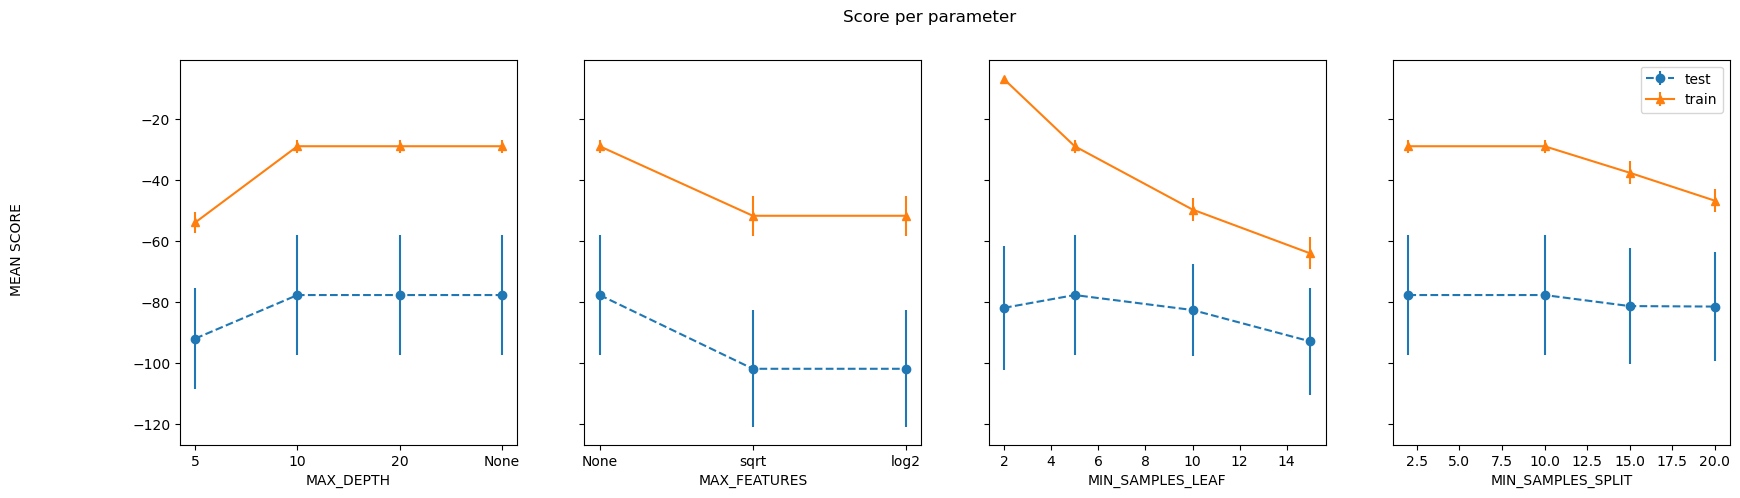

Best hyperparameters:



{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [91]:
plot_search_results(gs_ds)
print("Best hyperparameters:\n")
gs_ds.best_params_

In [92]:
my_best_model = gs_ds.best_estimator_

y_train_pred = my_best_model.predict(X_train)
y_test_pred = my_best_model.predict(X_test)

In [93]:
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
risk_feature_range = [df['risk'].min(), df['risk'].max()]

In [94]:
print(f"RMSE for training data: {train_rmse}\n")
print(f"RMSE for test data: {test_rmse}\n")
print(f"Target feature range: {risk_feature_range}")

RMSE for training data: 5.192941557904299

RMSE for test data: 8.27725159205413

Target feature range: [0.1, 85.4]


#### Based in targer feature range we can observe that error is quite high

#### Save model and dataset

In [95]:
def save_pickle(data, filepath):

    # save data as *.pickle file
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    f.close()

    print(f'{filepath} SAVED')

In [96]:
# Save model as .pickle
save_pickle(data=my_best_model, filepath='single_tree_model.pickle')

single_tree_model.pickle SAVED


In [97]:
# Save dataset
save_pickle(
    data=[X_train, y_train, X_test, y_test],
    filepath='dataset.pickle'
)

dataset.pickle SAVED


## <a id='random_forest'> Random Forest Model </a>

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 1/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=(train=-40.684, test=-53.799) total time=   0.0s
[CV 2/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=(train=-38.753, test=-50.285) total time=   0.0s
[CV 3/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=(train=-33.736, test=-83.563) total time=   0.0s
[CV 4/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=(train=-40.540, test=-60.993) total time=   0.0s
[CV 5/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=(train=-35.559, test=-72.055) total time=   0.0s
[CV 1/5] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=-36.559, test=-49.004) t

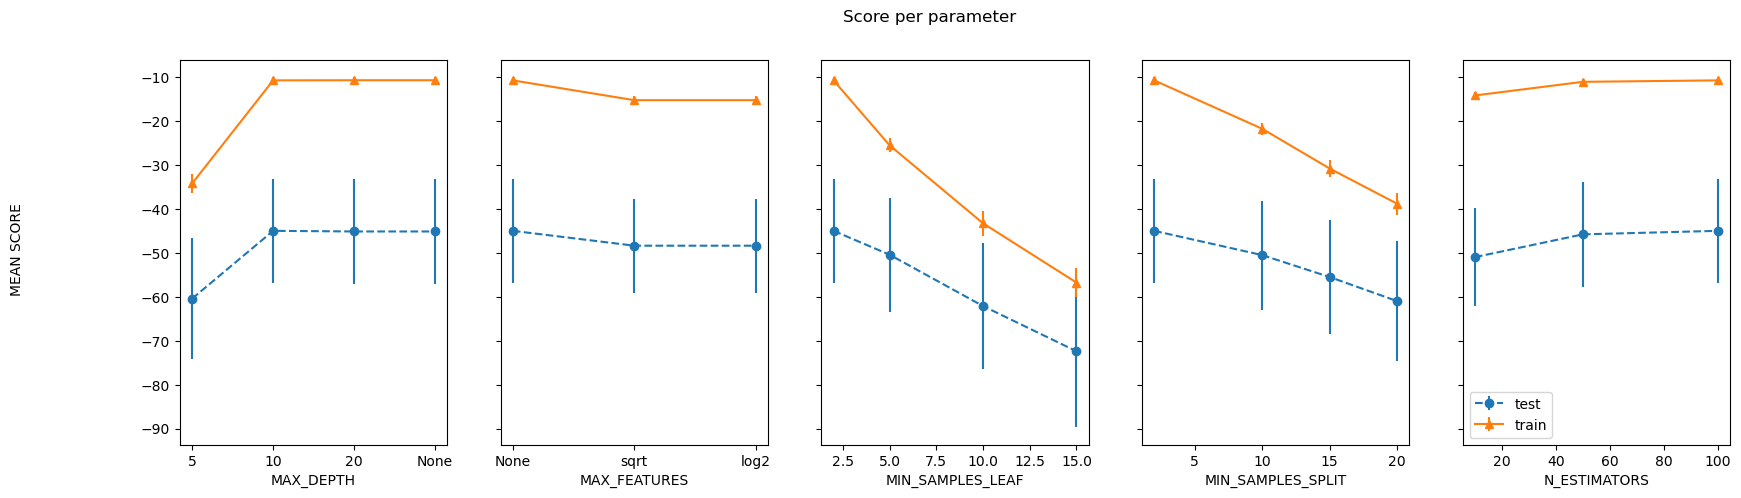

Best hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

RMSE for training data: 3.0962150712641345

RMSE for test data: 5.950096109686694

Target feature range: [0.1, 85.4]
random_forest_model.pickle SAVED


In [102]:
hparams_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 15],
    'max_features': [None, "sqrt", "log2"]
    }

model = RFRegressor(criterion = criterion, random_state = random_state) # init model
gs_ds = GridSearchCV(model, hparams_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 3, return_train_score = True) # init grid search
gs_ds.fit(X_train, y_train) # perform Grid Search Cross-Validation 

none_sub(gs_ds.param_grid) # change None to 'None' in order to plot Cross-Validation results

#Visualize results
plot_search_results(gs_ds)
print(f"Best hyperparameters: {gs_ds.best_params_}\n")

my_best_model = gs_ds.best_estimator_

# Predict
y_train_pred = my_best_model.predict(X_train)
y_test_pred = my_best_model.predict(X_test)

# Examine model performance
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
risk_feature_range = [df['risk'].min(), df['risk'].max()]

print(f"RMSE for training data: {train_rmse}\n")
print(f"RMSE for test data: {test_rmse}\n")
print(f"Target feature range: {risk_feature_range}")


# Save model as .pickle
save_pickle(data=my_best_model, filepath='random_forest_model.pickle')


#### We can notice that with ensemble of Decision Tree Regressors we've got much better results in terms of model performance.